In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_auc_score

In [20]:
mmlu_df = pd.read_csv(
    "../data/mmlu_pro_stem_final.tsv",
    sep="\t",
    header=0,
    escapechar="\\",
)
mmlu_df

mmlu_df.loc[mmlu_df["entropy_ans_correct_phi3"] == True, "entropy_ans_correct_phi3"] = 1
mmlu_df.loc[mmlu_df["entropy_ans_correct_phi3"] == False, "entropy_ans_correct_phi3"] = 0
# Ensure the target variable is in the correct format
mmlu_df["entropy_ans_correct_phi3"] = mmlu_df["entropy_ans_correct_phi3"].astype(int)

mmlu_df.loc[mmlu_df["entropy_ans_correct_mistral"] == True, "entropy_ans_correct_mistral"] = 1
mmlu_df.loc[mmlu_df["entropy_ans_correct_mistral"] == False, "entropy_ans_correct_mistral"] = 0
# Ensure the target variable is in the correct format
mmlu_df["entropy_ans_correct_mistral"] = mmlu_df["entropy_ans_correct_mistral"].astype(int)

mmlu_df["masj_nominal_complexity_norm"] = 0.0
mmlu_df.loc[mmlu_df["masj_nominal_complexity"] == "middle_school", "masj_nominal_complexity_norm"] = 0.1
mmlu_df.loc[mmlu_df["masj_nominal_complexity"] == "high_school", "masj_nominal_complexity_norm"] = 0.3
mmlu_df.loc[mmlu_df["masj_nominal_complexity"] == "undergraduate", "masj_nominal_complexity_norm"] = 0.5
mmlu_df.loc[mmlu_df["masj_nominal_complexity"] == "postgraduate", "masj_nominal_complexity_norm"] = 0.7
mmlu_df.loc[mmlu_df["masj_nominal_complexity"] == "phd", "masj_nominal_complexity_norm"] = 0.9
# Ensure the target variable is in the correct format
mmlu_df["masj_nominal_complexity_norm"] = mmlu_df["masj_nominal_complexity_norm"].astype(float)

/var/folders/62/r46p4vgs7m5bbync7hl0ykjc0000gp/T/ipykernel_50811/2529798226.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  mmlu_df.loc[mmlu_df["entropy_ans_correct_phi3"] == True, "entropy_ans_correct_phi3"] = 1
/var/folders/62/r46p4vgs7m5bbync7hl0ykjc0000gp/T/ipykernel_50811/2529798226.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  mmlu_df.loc[mmlu_df["entropy_ans_correct_mistral"] == True, "entropy_ans_correct_mistral"] = 1


In [21]:
# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_true=mmlu_df["entropy_ans_correct_mistral"], y_score=mmlu_df["entropy_value_mistral"])
print(f"ROC AUC Score: {roc_auc}")

ROC AUC Score: 0.5217119603445798


In [22]:
import numpy as np
import pandas as pd
from sklearn.metrics import auc, precision_recall_curve, roc_auc_score


def normalize_score(column):
    return 1 - column / column.max()


def calculate_metrics(y_true, y_score):
    """
    Рассчитывает ROC AUC, Precision-Recall AUC и Gini.
    """
    metrics = {}

    # print(y_true.shape)
    # print(y_score.shape)

    # ROC AUC
    try:
        roc_auc = roc_auc_score(y_true, y_score)
        metrics["roc_auc"] = roc_auc
        metrics["gini"] = abs(2 * roc_auc - 1)
    except ValueError:
        metrics["roc_auc"] = np.nan
        metrics["gini"] = np.nan

    # Precision-Recall AUC
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    pr_auc = auc(recall, precision)
    metrics["pr_auc"] = pr_auc

    return metrics


def evaluate_model(df, model_name, target_col, score_col):
    """
    Анализирует метрики для каждой категории и общей выборки.
    """
    results = []

    # print(df[score_col].head())
    # print(score_col_norm.head())
    # print(df)

    # Для всех данных
    metrics = calculate_metrics(df[target_col], normalize_score(df[score_col]))
    results.append(
        {
            "category": "ALL",
            "roc_auc": metrics["roc_auc"],
            "pr_auc": metrics["pr_auc"],
            "gini": metrics["gini"],
            "num_samples": len(df),
            "correct": df[target_col].sum(),
            "incorrect": len(df) - df[target_col].sum(),
            "model": model_name,
            "metric": score_col,
        }
    )

    # По категориям
    for category in df["category"].unique():
        df_cat = df[df["category"] == category]
        if len(df_cat) < 10:  # Пропустить категории с <10 примерами
            continue

        metrics = calculate_metrics(df_cat[target_col], normalize_score(df_cat[score_col]))

        results.append(
            {
                "category": category,
                "roc_auc": metrics["roc_auc"],
                "pr_auc": metrics["pr_auc"],
                "gini": metrics["gini"],
                "num_samples": len(df_cat),
                "correct": df_cat[target_col].sum(),
                "incorrect": len(df_cat) - df_cat[target_col].sum(),
                "model": model_name,
                "metric": score_col,
            }
        )

    # По ризонингу (да/нет)
    for requires_reasoning in df["masj_requires_reasoning"].unique():
        df_cat = df[df["masj_requires_reasoning"] == requires_reasoning]
        if len(df_cat) < 10:  # Пропустить категории с <10 примерами
            continue

        metrics = calculate_metrics(df_cat[target_col], normalize_score(df_cat[score_col]))

        results.append(
            {
                "category": "reasoning required" if requires_reasoning == "yes" else "no reasoning required",
                "roc_auc": metrics["roc_auc"],
                "pr_auc": metrics["pr_auc"],
                "gini": metrics["gini"],
                "num_samples": len(df_cat),
                "correct": df_cat[target_col].sum(),
                "incorrect": len(df_cat) - df_cat[target_col].sum(),
                "model": model_name,
                "metric": score_col,
            }
        )

    # По ризонингу (с уровнями сложности)
    for reasoning_steps in df["masj_num_reasoning_steps"].unique():
        df_cat = df[df["masj_num_reasoning_steps"] == reasoning_steps]
        if len(df_cat) < 10:  # Пропустить категории с <10 примерами
            continue

        metrics = calculate_metrics(df_cat[target_col], normalize_score(df_cat[score_col]))

        results.append(
            {
                "category": f"Reasoning ({reasoning_steps})",
                "roc_auc": metrics["roc_auc"],
                "pr_auc": metrics["pr_auc"],
                "gini": metrics["gini"],
                "num_samples": len(df_cat),
                "correct": df_cat[target_col].sum(),
                "incorrect": len(df_cat) - df_cat[target_col].sum(),
                "model": model_name,
                "metric": score_col,
            }
        )

    return pd.DataFrame(results)


results = []
results.append(evaluate_model(mmlu_df, "Phi-4", "entropy_ans_correct_phi3", "masj_nominal_complexity_norm"))
results.append(evaluate_model(mmlu_df, "Phi-4", "entropy_ans_correct_phi3", "masj_num_complexity"))
results.append(evaluate_model(mmlu_df, "Phi-4", "entropy_ans_correct_phi3", "entropy_value_phi3"))
results.append(
    evaluate_model(
        mmlu_df.dropna(subset=["masj_num_complexity"]),
        "Mistral",
        "entropy_ans_correct_mistral",
        "masj_num_complexity",
    )
)
results.append(evaluate_model(mmlu_df, "Mistral", "entropy_ans_correct_mistral", "entropy_value_mistral"))

final_results = pd.concat(results).reset_index(drop=True)


In [23]:
print("Phi-4 MASJ (numerical):")
final_results[(final_results["model"] == "Phi-4") & (final_results["metric"] == "masj_num_complexity")].sort_values(
    by="gini", ascending=False
)

Phi-4 MASJ (numerical):


,category,roc_auc,pr_auc,gini,num_samples,correct,incorrect,model,metric
22,business,0.413163,0.321194,0.173674,762,280,482,Phi-4,masj_num_complexity
29,computer science,0.565353,0.642990,0.130706,402,222,180,Phi-4,masj_num_complexity
25,biology,0.557685,0.836217,0.115371,715,568,147,Phi-4,masj_num_complexity
38,Reasoning (low),0.449032,0.593019,0.101936,2749,1769,980,Phi-4,masj_num_complexity
26,history,0.547764,0.589363,0.095529,381,236,145,Phi-4,masj_num_complexity
33,philosophy,0.546552,0.644670,0.093104,498,302,196,Phi-4,masj_num_complexity
39,Reasoning (high),0.459946,0.383412,0.080108,1052,436,616,Phi-4,masj_num_complexity
32,math,0.534440,0.415336,0.068881,1187,451,736,Phi-4,masj_num_complexity
31,economics,0.533276,0.709519,0.066552,833,575,258,Phi-4,masj_num_complexity
30,health,0.532162,0.643534,0.064324,720,459,261,Phi-4,masj_num_complexity


In [24]:
print("Phi-4 MASJ (nominal):")
final_results[
    (final_results["model"] == "Phi-4") & (final_results["metric"] == "masj_nominal_complexity_norm")
].sort_values(by="gini", ascending=False)

Phi-4 MASJ (nominal):


,category,roc_auc,pr_auc,gini,num_samples,correct,incorrect,model,metric
2,business,0.428853,0.349635,0.142294,762,280,482,Phi-4,masj_nominal_complexity_norm
5,biology,0.567937,0.836071,0.135875,715,568,147,Phi-4,masj_nominal_complexity_norm
9,computer science,0.552753,0.650813,0.105506,402,222,180,Phi-4,masj_nominal_complexity_norm
18,Reasoning (low),0.453672,0.617091,0.092657,2749,1769,980,Phi-4,masj_nominal_complexity_norm
8,physics,0.536637,0.452527,0.073273,1184,479,705,Phi-4,masj_nominal_complexity_norm
17,Reasoning (medium),0.476134,0.474229,0.047732,7429,3705,3724,Phi-4,masj_nominal_complexity_norm
19,Reasoning (high),0.477680,0.361380,0.044639,1052,436,616,Phi-4,masj_nominal_complexity_norm
15,reasoning required,0.477988,0.468414,0.044024,8933,4362,4571,Phi-4,masj_nominal_complexity_norm
7,other,0.521058,0.610152,0.042117,923,522,401,Phi-4,masj_nominal_complexity_norm
4,chemistry,0.518776,0.344020,0.037553,977,348,629,Phi-4,masj_nominal_complexity_norm


In [25]:
# Фильтрация и сортировка
print("Phi-4 Entropy:")
final_results[(final_results["model"] == "Phi-4") & (final_results["metric"] == "entropy_value_phi3")].sort_values(
    by="gini", ascending=False
)


Phi-4 Entropy:


,category,roc_auc,pr_auc,gini,num_samples,correct,incorrect,model,metric
45,biology,0.726250,0.894363,0.452501,715,568,147,Phi-4,entropy_value_phi3
51,economics,0.654297,0.802016,0.308595,833,575,258,Phi-4,entropy_value_phi3
53,philosophy,0.653500,0.727386,0.307001,498,302,196,Phi-4,entropy_value_phi3
48,physics,0.621203,0.559943,0.242405,1184,479,705,Phi-4,entropy_value_phi3
49,computer science,0.618018,0.654518,0.236036,402,222,180,Phi-4,entropy_value_phi3
43,psychology,0.610546,0.808566,0.221092,797,590,207,Phi-4,entropy_value_phi3
44,chemistry,0.610411,0.473647,0.220821,977,348,629,Phi-4,entropy_value_phi3
56,no reasoning required,0.604714,0.745479,0.209427,2299,1549,750,Phi-4,entropy_value_phi3
50,health,0.604554,0.714788,0.209109,720,459,261,Phi-4,entropy_value_phi3
58,Reasoning (low),0.594607,0.714303,0.189214,2749,1769,980,Phi-4,entropy_value_phi3


In [26]:
print("Mistral MASJ:")
final_results[(final_results["model"] == "Mistral") & (final_results["metric"] == "masj_num_complexity")].sort_values(
    by="gini", ascending=False
)


Mistral MASJ:


,category,roc_auc,pr_auc,gini,num_samples,correct,incorrect,model,metric
73,philosophy,0.563536,0.607249,0.127072,498,264,234,Mistral,masj_num_complexity
68,physics,0.557731,0.456017,0.115463,1184,461,723,Mistral,masj_num_complexity
72,math,0.546835,0.340406,0.093669,1187,389,798,Mistral,masj_num_complexity
69,computer science,0.544441,0.579598,0.088881,402,211,191,Mistral,masj_num_complexity
71,economics,0.539337,0.635792,0.078675,833,514,319,Mistral,masj_num_complexity
65,biology,0.534276,0.764943,0.068552,715,526,189,Mistral,masj_num_complexity
70,health,0.532511,0.631716,0.065021,720,435,285,Mistral,masj_num_complexity
63,psychology,0.532264,0.665693,0.064529,797,524,273,Mistral,masj_num_complexity
78,Reasoning (low),0.482639,0.554675,0.034722,2749,1614,1135,Mistral,masj_num_complexity
79,Reasoning (high),0.484402,0.364516,0.031197,1052,412,640,Mistral,masj_num_complexity


In [27]:
print("Mistral Entropy:")
final_results[(final_results["model"] == "Mistral") & (final_results["metric"] == "entropy_value_mistral")].sort_values(
    by="gini", ascending=False
)


Mistral Entropy:


,category,roc_auc,pr_auc,gini,num_samples,correct,incorrect,model,metric
83,psychology,0.351145,0.542106,0.297710,797,524,273,Mistral,entropy_value_mistral
85,biology,0.353049,0.627915,0.293902,715,526,189,Mistral,entropy_value_mistral
96,no reasoning required,0.409401,0.526972,0.181198,2299,1408,891,Mistral,entropy_value_mistral
86,history,0.419588,0.477220,0.160824,381,212,169,Mistral,entropy_value_mistral
91,economics,0.424728,0.538554,0.150543,833,514,319,Mistral,entropy_value_mistral
98,Reasoning (low),0.425699,0.510240,0.148603,2749,1614,1135,Mistral,entropy_value_mistral
81,law,0.431572,0.353265,0.136855,1037,422,615,Mistral,entropy_value_mistral
94,engineering,0.563381,0.496662,0.126763,819,373,446,Mistral,entropy_value_mistral
84,chemistry,0.562818,0.399866,0.125637,977,359,618,Mistral,entropy_value_mistral
89,computer science,0.441577,0.465692,0.116846,402,211,191,Mistral,entropy_value_mistral


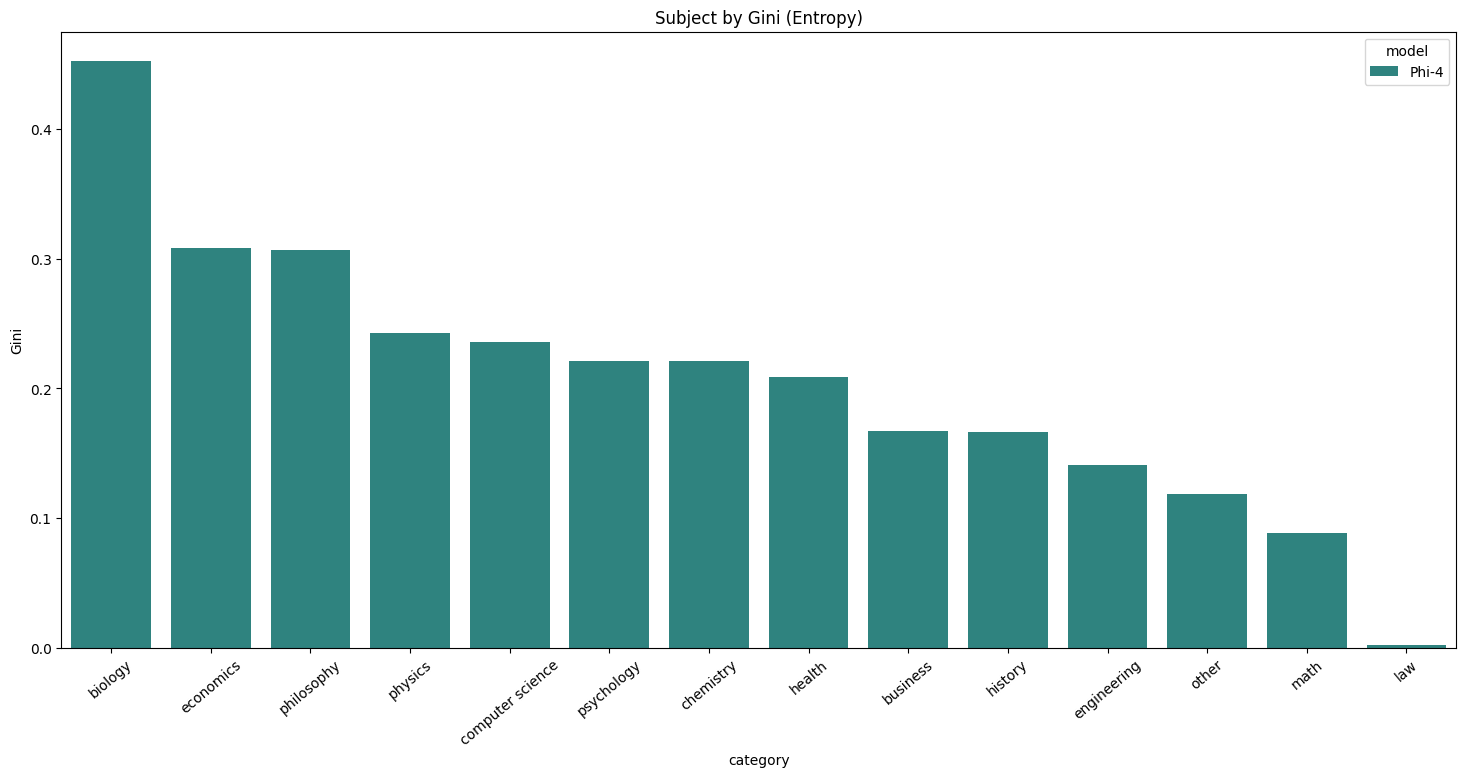

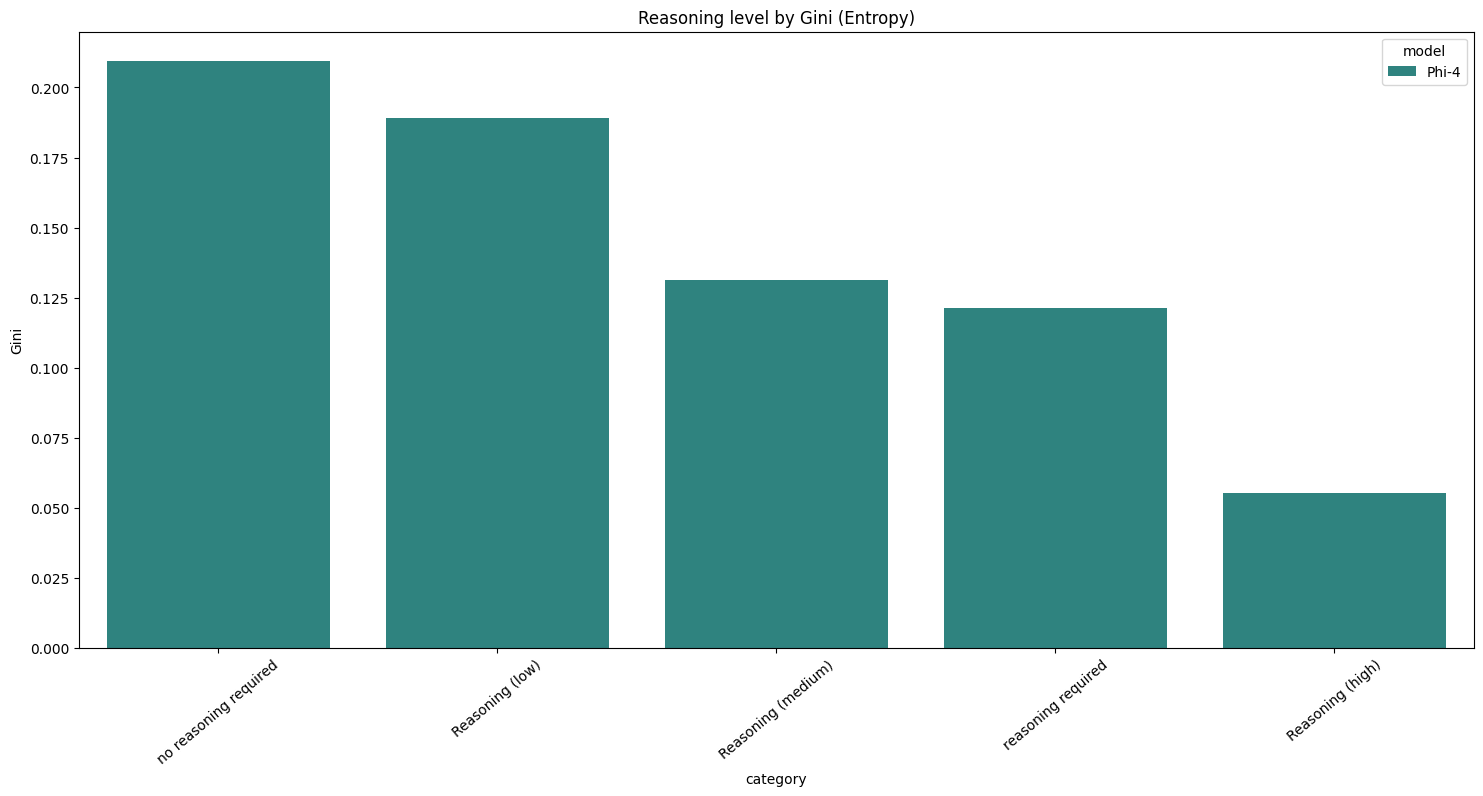

In [28]:
def plot_top_categories(df, metric_col, title):
    top_categories = (
        df[
            (df["metric"] == metric_col)
            & (
                ~df["category"].isin(
                    [
                        "ALL",
                        "reasoning required",
                        "no reasoning required",
                        "Reasoning (low)",
                        "Reasoning (medium)",
                        "Reasoning (high)",
                    ]
                )
            )
        ]
        .sort_values(by="gini", ascending=False)
        .head(15)
    )

    plt.figure(figsize=(18, 8))
    sns.barplot(data=top_categories, x="category", y="gini", hue="model", palette="viridis")
    plt.title(f"Subject by Gini ({title})")
    plt.ylabel("Gini")
    plt.xticks(rotation=40)
    plt.show()


def plot_reasoning(df, metric_col, title):
    top_categories = (
        df[
            (df["metric"] == metric_col)
            & (
                df["category"].isin(
                    [
                        "reasoning required",
                        "no reasoning required",
                        "Reasoning (low)",
                        "Reasoning (medium)",
                        "Reasoning (high)",
                    ]
                )
            )
        ]
        .sort_values(by="gini", ascending=False)
        .head(15)
    )

    plt.figure(figsize=(18, 8))
    sns.barplot(data=top_categories, x="category", y="gini", hue="model", palette="viridis")
    plt.title(f"Reasoning level by Gini ({title})")
    plt.ylabel("Gini")
    plt.xticks(rotation=40)
    plt.show()


plot_top_categories(final_results, "entropy_value_phi3", "Entropy")
plot_reasoning(final_results, "entropy_value_phi3", "Entropy")

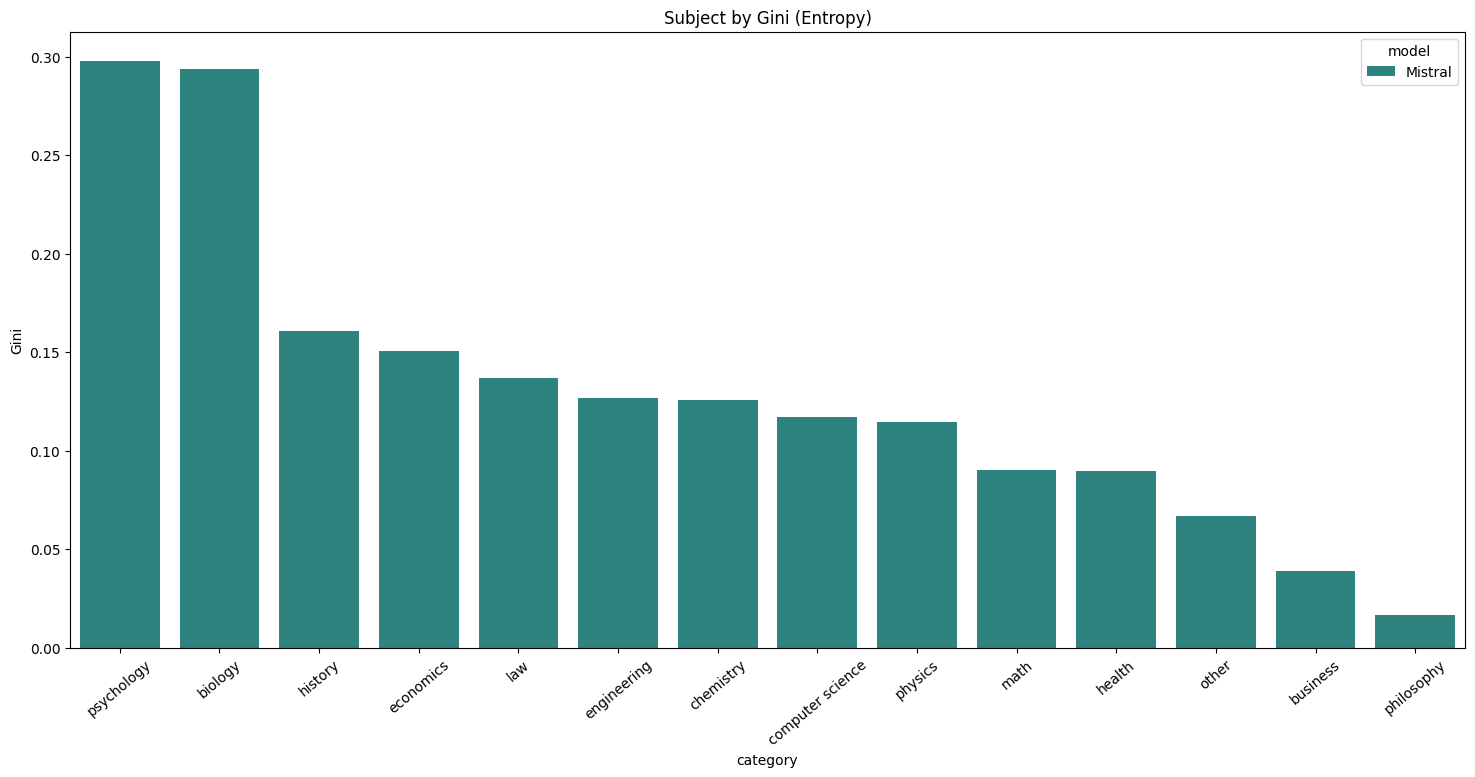

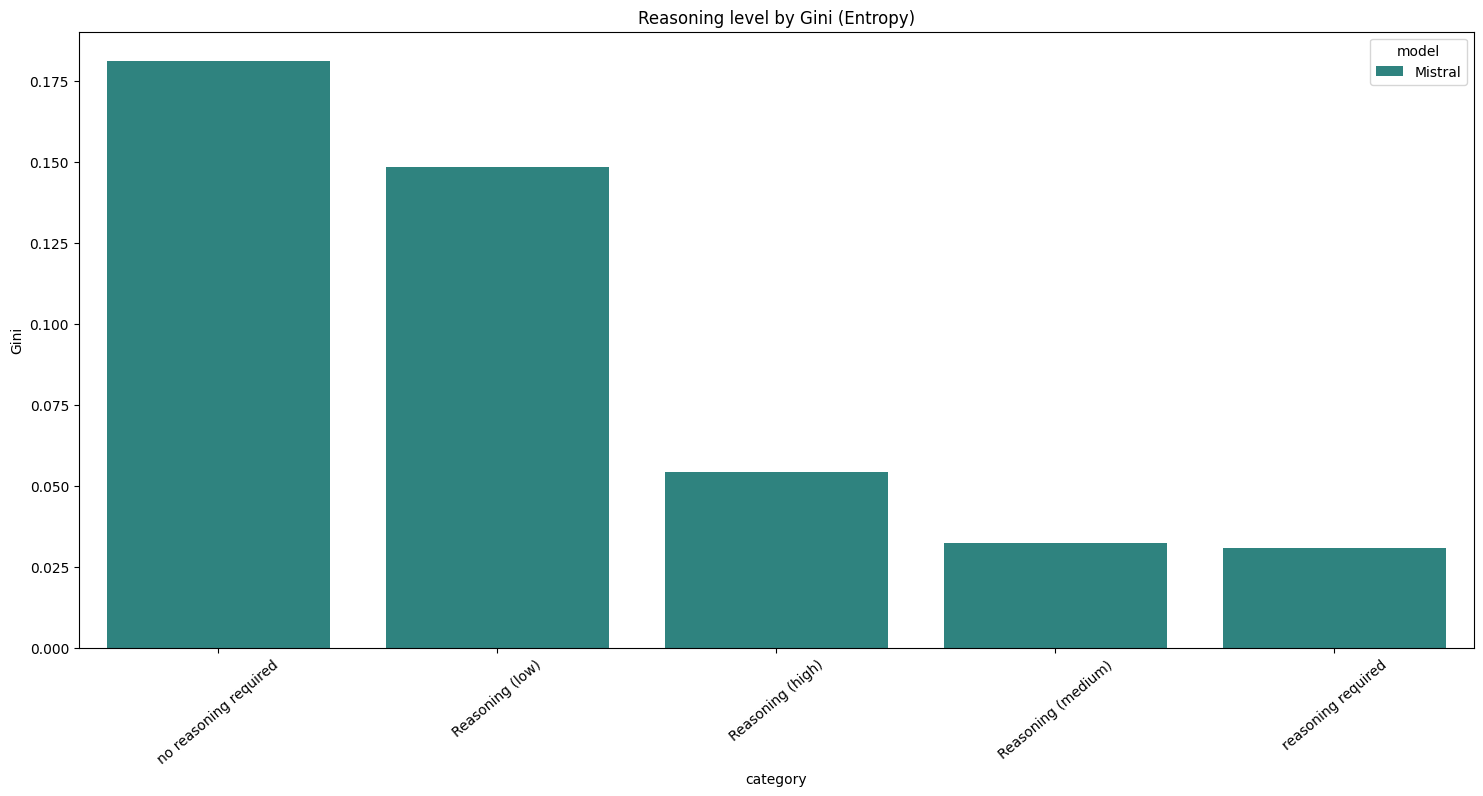

In [29]:
plot_top_categories(final_results, "entropy_value_mistral", "Entropy")
plot_reasoning(final_results, "entropy_value_mistral", "Entropy")

In [30]:
# Переделал функцию для категорий образования


def evaluate_question_model(df, model_name, target_col, score_col):
    """
    Анализирует метрики для каждой категории и общей выборки.
    """
    results = []

    # Для всех данных
    metrics = calculate_metrics(df[target_col], normalize_score(df[score_col]))
    results.append(
        {
            "category": "ALL",
            "roc_auc": metrics["roc_auc"],
            "pr_auc": metrics["pr_auc"],
            "gini": metrics["gini"],
            "num_samples": len(df),
            "correct": df[target_col].sum(),
            "incorrect": len(df) - df[target_col].sum(),
            "model": model_name,
            "metric": score_col,
        }
    )

    # По категориям
    for category in df["masj_nominal_complexity"].unique():
        df_cat = df[df["masj_nominal_complexity"] == category]
        if len(df_cat) < 10:  # Пропустить категории с <10 примерами
            continue

        metrics = calculate_metrics(df_cat[target_col], normalize_score(df_cat[score_col]))

        results.append(
            {
                "category": category,
                "roc_auc": metrics["roc_auc"],
                "pr_auc": metrics["pr_auc"],
                "gini": metrics["gini"],
                "num_samples": len(df_cat),
                "correct": df_cat[target_col].sum(),
                "incorrect": len(df_cat) - df_cat[target_col].sum(),
                "model": model_name,
                "metric": score_col,
            }
        )

    # По ризонингу (да/нет)
    for requires_reasoning in df["masj_requires_reasoning"].unique():
        df_cat = df[df["masj_requires_reasoning"] == requires_reasoning]
        if len(df_cat) < 10:  # Пропустить категории с <10 примерами
            continue

        metrics = calculate_metrics(df_cat[target_col], normalize_score(df_cat[score_col]))

        results.append(
            {
                "category": "reasoning required" if requires_reasoning == "yes" else "no reasoning required",
                "roc_auc": metrics["roc_auc"],
                "pr_auc": metrics["pr_auc"],
                "gini": metrics["gini"],
                "num_samples": len(df_cat),
                "correct": df_cat[target_col].sum(),
                "incorrect": len(df_cat) - df_cat[target_col].sum(),
                "model": model_name,
                "metric": score_col,
            }
        )

    # По ризонингу (с уровнями сложности)
    for reasoning_steps in df["masj_num_reasoning_steps"].unique():
        df_cat = df[df["masj_num_reasoning_steps"] == reasoning_steps]
        if len(df_cat) < 10:  # Пропустить категории с <10 примерами
            continue

        metrics = calculate_metrics(df_cat[target_col], normalize_score(df_cat[score_col]))

        results.append(
            {
                "category": f"Reasoning ({reasoning_steps})",
                "roc_auc": metrics["roc_auc"],
                "pr_auc": metrics["pr_auc"],
                "gini": metrics["gini"],
                "num_samples": len(df_cat),
                "correct": df_cat[target_col].sum(),
                "incorrect": len(df_cat) - df_cat[target_col].sum(),
                "model": model_name,
                "metric": score_col,
            }
        )

    return pd.DataFrame(results)


evaluate_question_model(mmlu_df, "Phi-4", "entropy_ans_correct_phi3", "entropy_value_phi3").sort_values(
    by="gini", ascending=False
)

,category,roc_auc,pr_auc,gini,num_samples,correct,incorrect,model,metric
5,phd,0.833333,0.793651,0.666667,11,3,8,Phi-4,entropy_value_phi3
4,middle_school,0.649863,0.611495,0.299726,655,299,356,Phi-4,entropy_value_phi3
3,high_school,0.623335,0.652444,0.246669,2862,1486,1376,Phi-4,entropy_value_phi3
7,no reasoning required,0.604714,0.745479,0.209427,2299,1549,750,Phi-4,entropy_value_phi3
9,Reasoning (low),0.594607,0.714303,0.189214,2749,1769,980,Phi-4,entropy_value_phi3
0,ALL,0.583533,0.610136,0.167066,11235,5912,5323,Phi-4,entropy_value_phi3
2,undergraduate,0.575302,0.607802,0.150603,7113,3830,3283,Phi-4,entropy_value_phi3
8,Reasoning (medium),0.565650,0.564507,0.131301,7429,3705,3724,Phi-4,entropy_value_phi3
6,reasoning required,0.560638,0.549698,0.121276,8933,4362,4571,Phi-4,entropy_value_phi3
1,postgraduate,0.533968,0.527649,0.067937,594,294,300,Phi-4,entropy_value_phi3


In [31]:
category_phi = evaluate_question_model(mmlu_df, "Phi-4", "entropy_ans_correct_phi3", "entropy_value_phi3").sort_values(
    by="gini", ascending=False
)

In [32]:
# mmlu_df["masj_nominal_complexity"] = mmlu_df["question_id"].map(
#     mmlu_df.set_index("question_id")["masj_nominal_complexity"]
# )
mmlu_df["masj_nominal_complexity"].value_counts()

masj_nominal_complexity
undergraduate    7113
high_school      2862
middle_school     655
postgraduate      594
phd                11
Name: count, dtype: int64

In [33]:
evaluate_question_model(mmlu_df, "Mistral", "entropy_ans_correct_mistral", "entropy_value_mistral").sort_values(
    by="gini", ascending=False
)

,category,roc_auc,pr_auc,gini,num_samples,correct,incorrect,model,metric
7,no reasoning required,0.409401,0.526972,0.181198,2299,1408,891,Mistral,entropy_value_mistral
9,Reasoning (low),0.425699,0.510240,0.148603,2749,1614,1135,Mistral,entropy_value_mistral
1,postgraduate,0.455477,0.375571,0.089047,594,250,344,Mistral,entropy_value_mistral
5,phd,0.458333,0.237037,0.083333,11,3,8,Mistral,entropy_value_mistral
3,high_school,0.466972,0.449894,0.066056,2862,1427,1435,Mistral,entropy_value_mistral
10,Reasoning (high),0.472831,0.358836,0.054339,1052,412,640,Mistral,entropy_value_mistral
0,ALL,0.478288,0.446376,0.043424,11235,5463,5772,Mistral,entropy_value_mistral
2,undergraduate,0.481553,0.454314,0.036893,7113,3496,3617,Mistral,entropy_value_mistral
8,Reasoning (medium),0.483777,0.427516,0.032446,7429,3437,3992,Mistral,entropy_value_mistral
6,reasoning required,0.484550,0.420452,0.030901,8933,4055,4878,Mistral,entropy_value_mistral


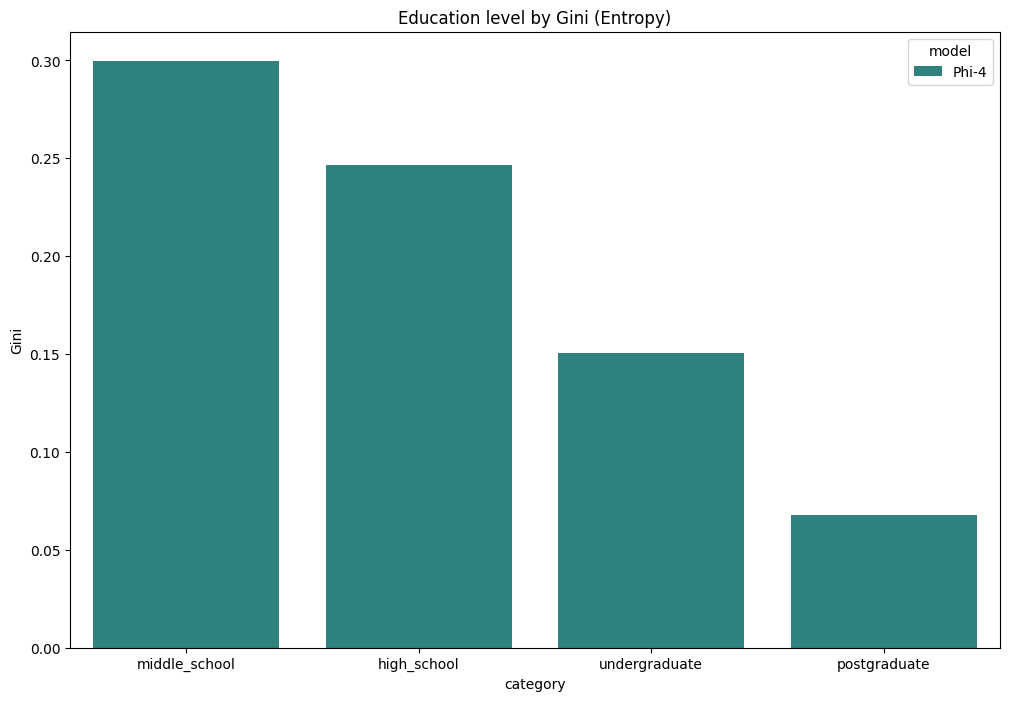

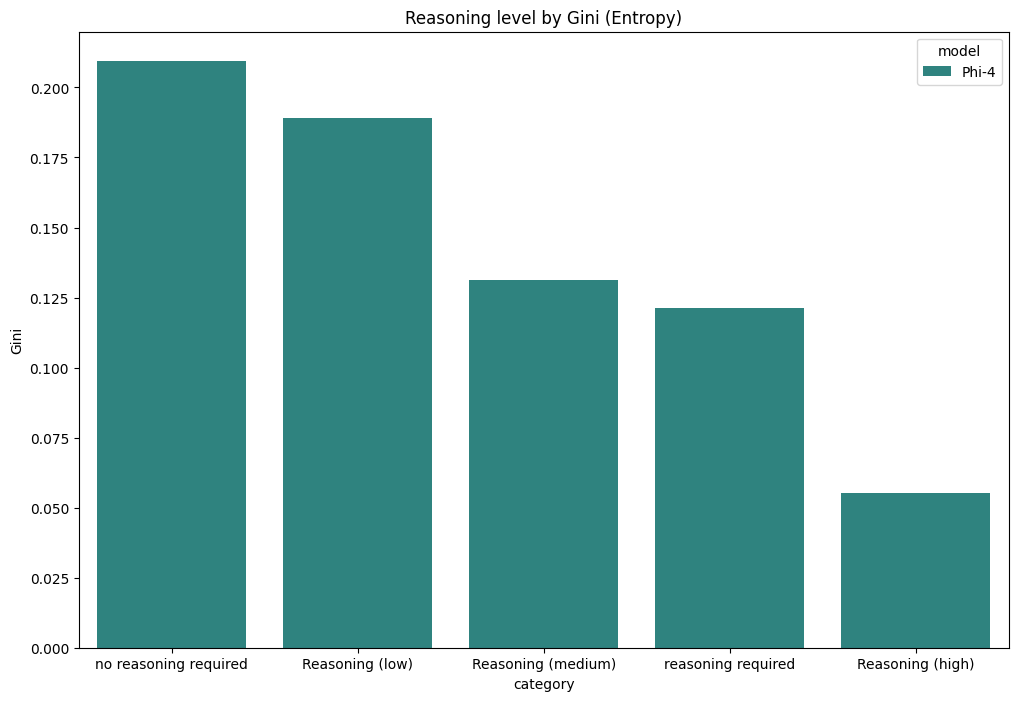

In [34]:
def plot_top_categories(df, metric_col, title):
    top_categories = (
        df[
            (df["metric"] == metric_col)
            & (
                ~df["category"].isin(
                    [
                        "phd",
                        "ALL",
                        "reasoning required",
                        "no reasoning required",
                        "Reasoning (low)",
                        "Reasoning (medium)",
                        "Reasoning (high)",
                    ]
                )
            )
        ]
        .sort_values(by="gini", ascending=False)
        .head(20)
    )

    plt.figure(figsize=(12, 8))
    sns.barplot(data=top_categories, x="category", y="gini", hue="model", palette="viridis")
    plt.title(f"Education level by Gini ({title})")
    plt.ylabel("Gini")
    plt.show()


def plot_reasoning(df, metric_col, title):
    top_categories = (
        df[
            (df["metric"] == metric_col)
            & (
                df["category"].isin(
                    [
                        "reasoning required",
                        "no reasoning required",
                        "Reasoning (low)",
                        "Reasoning (medium)",
                        "Reasoning (high)",
                    ]
                )
            )
        ]
        .sort_values(by="gini", ascending=False)
        .head(20)
    )

    plt.figure(figsize=(12, 8))
    sns.barplot(data=top_categories, x="category", y="gini", hue="model", palette="viridis")
    plt.title(f"Reasoning level by Gini ({title})")
    plt.ylabel("Gini")
    plt.show()


plot_top_categories(category_phi, "entropy_value_phi3", "Entropy")
plot_reasoning(category_phi, "entropy_value_phi3", "Entropy")

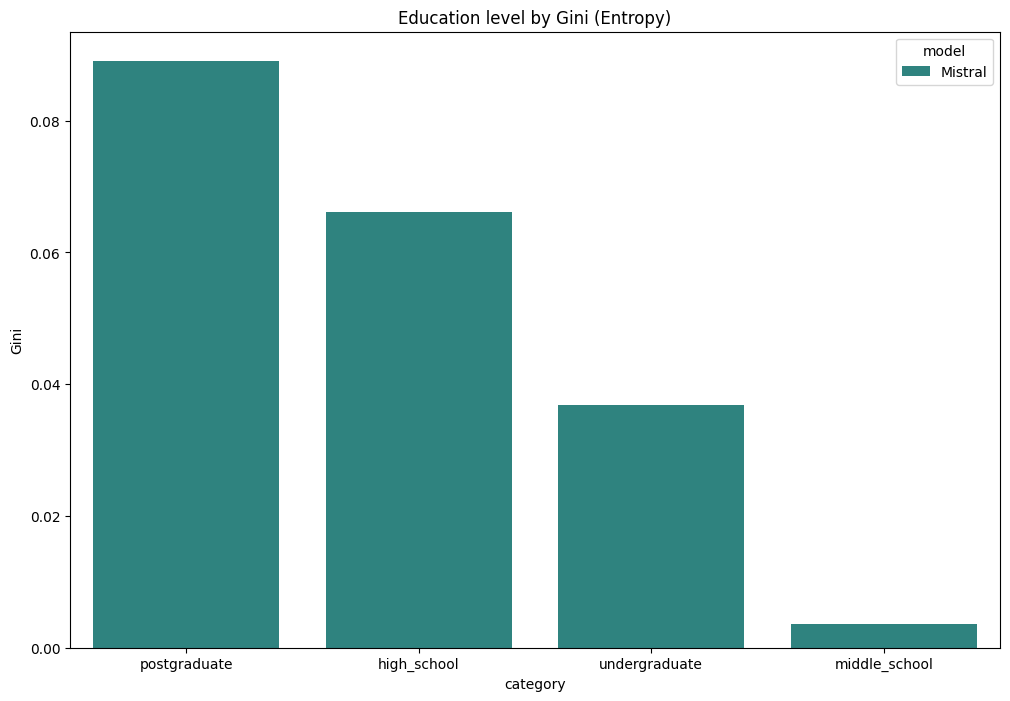

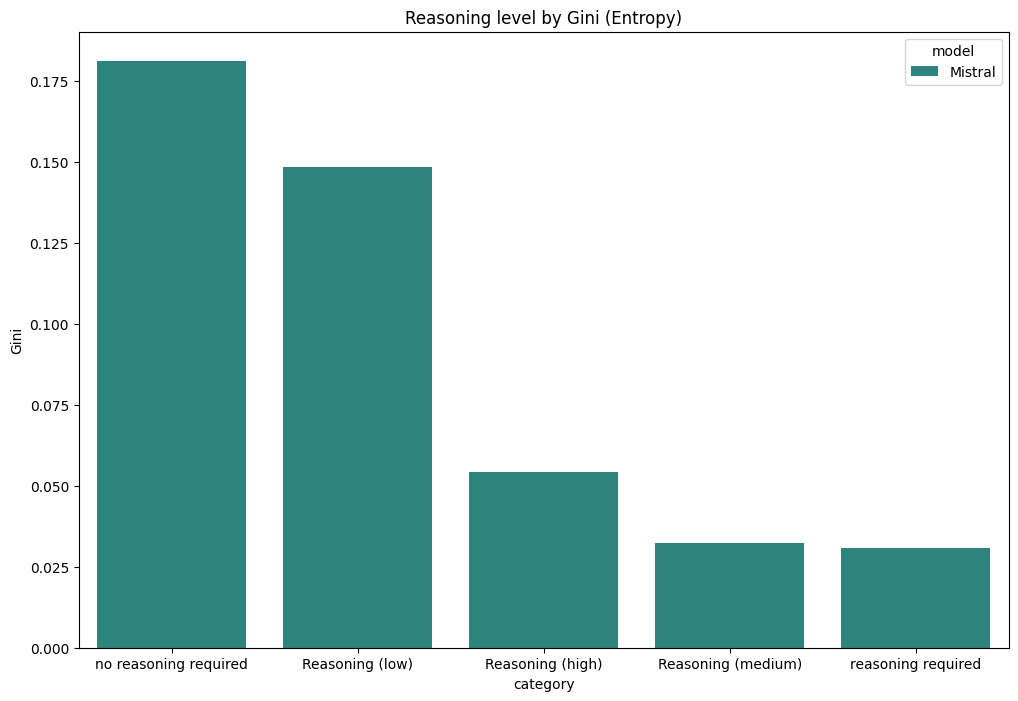

In [35]:
category_mistral = evaluate_question_model(
    mmlu_df, "Mistral", "entropy_ans_correct_mistral", "entropy_value_mistral"
).sort_values(by="gini", ascending=False)

plot_top_categories(category_mistral, "entropy_value_mistral", "Entropy")
plot_reasoning(category_mistral, "entropy_value_mistral", "Entropy")